In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import cv2

import tensorflow as tf
os.getcwd()

Using TensorFlow backend.


'/kaggle/working'

In [3]:
data_directory = '/kaggle/input/data/'
image_size = 256
batch_size = 32
os.chdir(data_directory)

In [4]:
df = pd.read_csv('Data_Entry_2017.csv')
os.chdir('/kaggle/working')

In [5]:
print('Total Number of Chest X-ray Images:',len(df))

Total Number of Chest X-ray Images: 112120


In [6]:
# Number of patients whose data is available
print('Total number of unique patients:',len(df['Patient ID'].unique()))

Total number of unique patients: 30805


In [7]:
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(data_directory, 'images*', '*', '*.png'))}
df['path'] = df['Image Index'].map(data_image_paths.get)
df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000001_...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000001_...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/kaggle/input/data/images_001/images/00000001_...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/kaggle/input/data/images_001/images/00000002_...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000003_...


In [8]:
# finding unique labels
l=list(map(lambda x:x.split('|'),list(df['Finding Labels'].unique())))
labels=[]
for i in l:
    for j in i:
        if j not in labels:
            labels.append(j)
labels


['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'No Finding',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

In [10]:
# generating new columns for each unique disease
l=list(map(lambda x:x.split('|'),list(df['Finding Labels'])))
for i in labels:
    new=list(map((lambda x: 1.0 if i in x else 0.0),l))
    df[i]=new
df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Finding how many xrays are available per disease
dd=pd.DataFrame()
s=[int(df[i].sum()) for i in labels]
dd['labels']=labels
dd['count']=s
dd=dd.sort_values(by='count',ascending=False).reset_index()
dd=dd.drop('index',axis=1)
dd

,labels,count
0,Infiltration,19894
1,Effusion,13317
2,Atelectasis,11559
3,Nodule,6331
4,Mass,5782
5,Pneumothorax,5302
6,Consolidation,4667
7,Pleural_Thickening,3385
8,Cardiomegaly,2776
9,Emphysema,2516


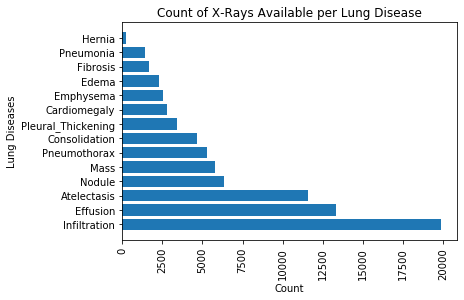

In [12]:
#Plot for Number of xrays for each Disease
plt.barh(dd['labels'],dd['count'])
plt.xticks(rotation=90)
plt.xlabel('Count')
plt.ylabel('Lung Diseases')
plt.title('Count of X-Rays Available per Lung Disease')
plt.show()

In [9]:
labels.remove('No Finding')
labels.remove('Hernia')

In [13]:
dd=dd.drop(dd[dd['count']<1000].index)
dd

,labels,count
0,Infiltration,19894
1,Effusion,13317
2,Atelectasis,11559
3,Nodule,6331
4,Mass,5782
5,Pneumothorax,5302
6,Consolidation,4667
7,Pleural_Thickening,3385
8,Cardiomegaly,2776
9,Emphysema,2516


In [14]:
# generating labels type since the data contain xrays with multiple diseases and xrays with just one disease
# for now we will focus on single disease
l=[]
for i in list(df['Finding Labels']):
    if len(i.split('|'))>1:
        l.append('Multiple')
    else:
        l.append('Simple')
df['Label Type']=l
df=df.drop(df[df['Label Type']=='Multiple'].index,axis=0)


In [18]:
# Removing normal/NO-Finding labelled images and Hernia Images
df=df.drop(df[df['Finding Labels']=='No Finding'].index,axis=0)
df=df.drop(df[df['Finding Labels']=='Hernia'].index,axis=0)

In [22]:
df['labels']=df['Finding Labels'] #since we have removed x-rays with multiple disease

In [47]:
df['Finding Labels'].value_counts()

Infiltration          9547
Atelectasis           4215
Effusion              3955
Nodule                2705
Pneumothorax          2194
Mass                  2139
Consolidation         1310
Pleural_Thickening    1126
Cardiomegaly          1093
Emphysema              892
Fibrosis               727
Edema                  628
Pneumonia              322
Name: Finding Labels, dtype: int64

In [23]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=2018, stratify=df['Finding Labels'].map(lambda x: x[:4]))

In [27]:
core_idg = ImageDataGenerator(rescale=1 / 255,
                                  samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  height_shift_range=0.05,
                                  width_shift_range=0.1,
                                  rotation_range=5,
                                  shear_range=0.1,
                                  fill_mode='reflect',
                                  zoom_range=0.15)

train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                                       directory=None,
                                                       x_col='path',
                                                       y_col='labels',
                                                       class_mode='categorical',
                                                       batch_size=1024,
                                                       classes=labels,
                                                       target_size=(image_size, image_size)))

Found 24682 validated image filenames belonging to 13 classes.
Found 6171 validated image filenames belonging to 13 classes.
Found 6171 validated image filenames belonging to 13 classes.


In [28]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(len(labels), activation="sigmoid")(x)
model = tf.keras.Model(base_model.input, output)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

219062272/219055592 [==============================] - 8s 0us/step


In [29]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{model_name}.h5',
        verbose=1,
        save_best_only=True)
    callbacks.append(checkpoint)
    return callbacks

In [30]:
callbacks = get_callbacks('multi_class')
model.fit(train_gen,
              steps_per_epoch=100,
              validation_data=(test_X, test_Y),
              epochs=20,
              callbacks=callbacks)

Train for 100 steps, validate on 1024 samples
Epoch 1/20
 99/100 [============================>.] - ETA: 1s - loss: 0.2682 - accuracy: 0.9138
Epoch 00001: val_loss improved from inf to 0.36157, saving model to multi_class.h5
100/100 [==============================] - 175s 2s/step - loss: 0.2677 - accuracy: 0.9138 - val_loss: 0.3616 - val_accuracy: 0.9201
Epoch 2/20
 99/100 [============================>.] - ETA: 1s - loss: 0.2440 - accuracy: 0.9213
Epoch 00002: val_loss improved from 0.36157 to 0.24276, saving model to multi_class.h5
100/100 [==============================] - 142s 1s/step - loss: 0.2437 - accuracy: 0.9213 - val_loss: 0.2428 - val_accuracy: 0.9247
Epoch 3/20
 99/100 [============================>.] - ETA: 1s - loss: 0.2381 - accuracy: 0.9230
Epoch 00003: val_loss did not improve from 0.24276
100/100 [==============================] - 137s 1s/step - loss: 0.2379 - accuracy: 0.9230 - val_loss: 0.2456 - val_accuracy: 0.9231
Epoch 4/20
 99/100 [============================>

In [65]:
y_pred = model.predict(test_X)

In [57]:
score=model.evaluate(test_X,test_Y)
print('Accuracy:',score[1]*100)

1024/1024 [==============================] - 5s 5ms/sample - loss: 0.2593 - accuracy: 0.9250
Accuracy: 92.5029993057251


Text(0, 0.5, 'True Positive Rate')

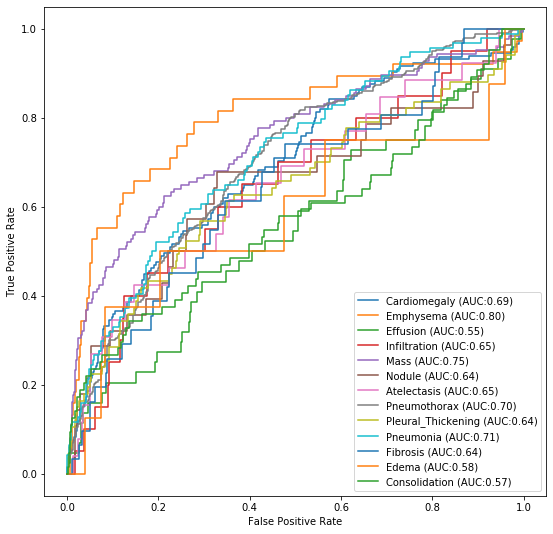

In [33]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

activation_166 (Activation)     (None, 6, 6, 256)    0           batch_normalization_166[0][0]    
__________________________________________________________________________________________________
block8_1_mixed (Concatenate)    (None, 6, 6, 448)    0           activation_163[0][0]             
                                                                 activation_166[0][0]             
__________________________________________________________________________________________________
block8_1_conv (Conv2D)          (None, 6, 6, 2080)   933920      block8_1_mixed[0][0]             
__________________________________________________________________________________________________
block8_1 (Lambda)               (None, 6, 6, 2080)   0           mixed_7a[0][0]                   
                                                                 block8_1_conv[0][0]              
__________________________________________________________________________________________________
block8_1_a